# Sedona read raster data
In this seminar, we will use [sedona raster loader](https://sedona.apache.org/latest-snapshot/api/sql/Raster-loader/) to read various raster data formats:
- **GeoTIFF**: is a public domain metadata standard that allows `georeferencing` information to be embedded within a `TIFF` file.
- **NetCDF**: a file format for storing multidimensional scientific data (variables) such as temperature, humidity, pressure, wind speed, and direction. Each of these variables can be displayed through a dimension (such as time) in ArcGIS by making a layer or table view from the netCDF file.

> The potential additional information includes [map projection](https://en.wikipedia.org/wiki/Map_projection), [coordinate systems](https://en.wikipedia.org/wiki/Coordinate_system), [ellipsoids](https://en.wikipedia.org/wiki/Ellipsoid), [datums](https://en.wikipedia.org/wiki/Datum_(geodesy)), and everything else necessary to establish the exact spatial reference for the file.

## Source data

The `NetCDF` sample data(sea_surface_temperature_O1_2001-2002.nc) is from https://www.unidata.ucar.edu/software/netcdf/examples/files.html. It describes sea surface temperatures collected by `PCMDI` for use by the `IPCC`.


The `geotiff` sample data() is from https://www.planetobserver.com/geospatial-data-samples. It describes the global elevation of San Francisco USA.



In [39]:
from sedona.spark import *
from pathlib import Path
import pyspark.sql.functions as f
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from matplotlib import cm
import folium
import rasterio.features

In [36]:
def open_and_visualize_geotiff(file_path):
    """
    Open and visualize a GeoTIFF file
    """
    # Open the raster file
    with rasterio.open(file_path) as src:
        # Read the data
        data = src.read(1)  # Read the first band

        # Get metadata
        print(f"Width: {src.width}, Height: {src.height}")
        print(f"Coordinate Reference System: {src.crs}")
        print(f"Bounds: {src.bounds}")

        # Create a figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot the data using rasterio's show function
        image = show(src, ax=ax, title="GeoTIFF Visualization")

        # Add a colorbar
        cbar = plt.colorbar(image, ax=ax, shrink=0.6)
        cbar.set_label('Value')

        # Optional: Create a custom colormap for better visualization
        # Uncomment if you want to use a custom colormap
        """
        # Create a custom colormap
        colors = ['blue', 'green', 'yellow', 'red']
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

        # Plot with custom colormap
        image = show(src, ax=ax, cmap=cmap, title="GeoTIFF Visualization with Custom Colormap")
        cbar = plt.colorbar(image, ax=ax, shrink=0.6)
        cbar.set_label('Value')
        """

        plt.tight_layout()
        plt.show()

        return data, src.meta

In [46]:
import io
import base64
def geotiff_to_folium(geotiff_path, output_html='geotiff_map.html', colormap='viridis', opacity=0.7):
    """
    Create an interactive Folium map from a GeoTIFF file

    Parameters:
    -----------
    geotiff_path : str
        Path to the GeoTIFF file
    output_html : str
        Path where the HTML map will be saved
    colormap : str
        Matplotlib colormap to use for the visualization
    opacity : float
        Opacity of the GeoTIFF overlay (0-1)

    Returns:
    --------
    str : Path to the saved HTML file
    """
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        # Get the center of the GeoTIFF
        bounds = src.bounds
        center_lon = (bounds.left + bounds.right) / 2
        center_lat = (bounds.bottom + bounds.top) / 2

        # Create a map centered on the GeoTIFF
        m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

        # Method 1: Export the visualization as a PNG image
        fig, ax = plt.subplots(figsize=(10, 10))
        rasterio.plot.show(src, ax=ax, cmap=colormap)
        ax.set_axis_off()

        # Save plot to a PNG image in memory
        img_data = io.BytesIO()
        plt.savefig(img_data, format='png', bbox_inches='tight', pad_inches=0)
        img_data.seek(0)
        plt.close()

        # Encode the image to base64 string
        encoded = base64.b64encode(img_data.read()).decode()

        # Add the image overlay to the map
        image_overlay = folium.raster_layers.ImageOverlay(
            image=f"data:image/png;base64,{encoded}",
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=opacity,
            name='GeoTIFF Layer'
        )
        image_overlay.add_to(m)

        # Add basemap options
        folium.TileLayer('OpenStreetMap').add_to(m)

        # Add layer control and other UI elements
        folium.LayerControl().add_to(m)

        # Save the map
        m.save(output_html)

    return output_html



In [4]:
# build a sedona session offline
project_root_dir = Path.cwd().parent.parent

print(project_root_dir.as_posix())

/home/pliu/git/ConstanceDataPlatform


In [5]:
sedona_version = "sedona-35-213-161"
jar_folder = Path(f"{project_root_dir}/jars/{sedona_version}")
jar_list = [str(jar) for jar in jar_folder.iterdir() if jar.is_file()]
jar_path = ",".join(jar_list)

# build a sedona session (sedona = 1.6.1) offline
config = SedonaContext.builder() \
    .master("local[*]") \
    .config('spark.jars', jar_path). \
    getOrCreate()

25/05/05 15:21:30 WARN Utils: Your hostname, pliu-ubuntu24 resolves to a loopback address: 127.0.1.1; using 192.168.30.128 instead (on interface ens33)
25/05/05 15:21:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/05/05 15:21:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
# create a sedona context
sedona = SedonaContext.create(config)

#

In [7]:
# get the spark context
sc = sedona.sparkContext

# use utf as default encoding
sc.setSystemProperty("sedona.global.charset", "utf8")

In [8]:
data_dir = f"{project_root_dir}/data"
netcdf_sample = f"{data_dir}/netcdf/sea_surface_temperature_O1_2001-2002.nc"
geotiff_sample = f"{data_dir}/geotiff/PlanetDEM_3s_SanFrancisco.tif"

##  Read geo tiff sample data

Width: 1200, Height: 1200
Coordinate Reference System: EPSG:4326
Bounds: BoundingBox(left=-123.0, bottom=37.00000000000001, right=-122.0, top=38.0)


AttributeError: 'Axes' object has no attribute 'cmap'

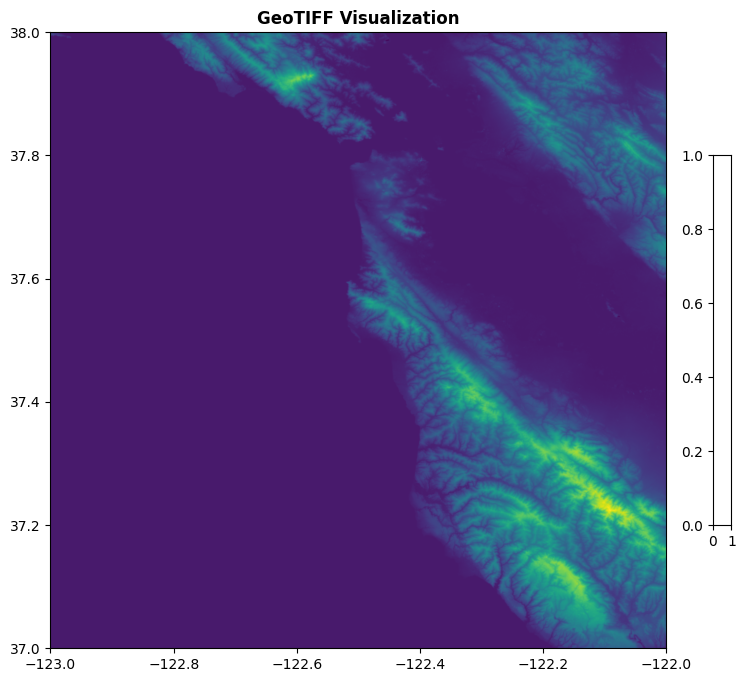

In [48]:
open_and_visualize_geotiff(geotiff_sample)


In [ ]:
# over match the geotiff with a map
geo_tiff_interactive_map = f"{data_dir}/tmp/geotiff_map.html"
geotiff_to_folium(geotiff_sample, output_html=geo_tiff_interactive_map)

In [13]:
raw_geotiff = sedona.read.format("binaryFile").load(geotiff_sample)

raw_geotiff.show(5)

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/home/pliu/g...|2025-05-05 15:18:...|2890124|[49 49 2A 00 08 F...|
+--------------------+--------------------+-------+--------------------+



In [14]:
raw_geotiff.createOrReplaceTempView("raw_geotiff")

In [16]:
geotiff_df = raw_geotiff.withColumn("raster", f.expr("RS_FromGeoTiff(content)")).select("modificationTime","raster","content")
geotiff_df.show(10)

+--------------------+--------------------+--------------------+
|    modificationTime|              raster|             content|
+--------------------+--------------------+--------------------+
|2025-05-05 15:18:...|GridCoverage2D["g...|[49 49 2A 00 08 F...|
+--------------------+--------------------+--------------------+



In [21]:
geotiff_df.printSchema()

root
 |-- modificationTime: timestamp (nullable = true)
 |-- raster: raster (nullable = true)
 |-- content: binary (nullable = true)



In [22]:
print(type(geotiff_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [17]:
geotiff_df.select("raster").show(1, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|raster                                                                                                                                                                                                                                                                                    |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|GridCoverage2D["geotiff_coverage", GeneralEnvelope[(-123.0, 37.00000000000001), (-122.0, 38.0)], DefaultGeographicCRS["WGS 84"]]\n│   RenderedSa

In [24]:
geotiff_parquet_out_path = f"{data_dir}/tmp/raster/geotiff"
geotiff_df.select("raster").write.mode("overwrite").parquet(geotiff_parquet_out_path)

25/05/05 15:44:16 ERROR Executor: Exception in task 0.0 in stage 10.0 (TID 9)
org.apache.spark.SparkIllegalArgumentException: [UNSUPPORTED_DATATYPE] Unsupported data type {"type":"struct","fields":[{"name":"raster","type":{"type":"udt","class":"org.apache.spark.sql.sedona_sql.UDT.RasterUDT$","pyClass":"sedona.sql.types.RasterType","sqlType":"binary"},"nullable":true,"metadata":{}}]}[1.1] failure: 'TimestampType' expected but '{' found

{"type":"struct","fields":[{"name":"raster","type":{"type":"udt","class":"org.apache.spark.sql.sedona_sql.UDT.RasterUDT$","pyClass":"sedona.sql.types.RasterType","sqlType":"binary"},"nullable":true,"metadata":{}}]}
^.
	at org.apache.spark.sql.errors.DataTypeErrors$.dataTypeUnsupportedError(DataTypeErrors.scala:176)
	at org.apache.spark.sql.catalyst.parser.LegacyTypeStringParser$.parseString(LegacyTypeStringParser.scala:91)
	at org.apache.spark.sql.types.StructType$.$anonfun$fromString$2(StructType.scala:513)
	at scala.util.Failure.getOrElse(Try.scala:219

Py4JJavaError: An error occurred while calling o172.parquet.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 10.0 failed 1 times, most recent failure: Lost task 0.0 in stage 10.0 (TID 9) (192.168.30.128 executor driver): org.apache.spark.SparkIllegalArgumentException: [UNSUPPORTED_DATATYPE] Unsupported data type {"type":"struct","fields":[{"name":"raster","type":{"type":"udt","class":"org.apache.spark.sql.sedona_sql.UDT.RasterUDT$","pyClass":"sedona.sql.types.RasterType","sqlType":"binary"},"nullable":true,"metadata":{}}]}[1.1] failure: 'TimestampType' expected but '{' found

{"type":"struct","fields":[{"name":"raster","type":{"type":"udt","class":"org.apache.spark.sql.sedona_sql.UDT.RasterUDT$","pyClass":"sedona.sql.types.RasterType","sqlType":"binary"},"nullable":true,"metadata":{}}]}
^.
	at org.apache.spark.sql.errors.DataTypeErrors$.dataTypeUnsupportedError(DataTypeErrors.scala:176)
	at org.apache.spark.sql.catalyst.parser.LegacyTypeStringParser$.parseString(LegacyTypeStringParser.scala:91)
	at org.apache.spark.sql.types.StructType$.$anonfun$fromString$2(StructType.scala:513)
	at scala.util.Failure.getOrElse(Try.scala:219)
	at org.apache.spark.sql.types.StructType$.fromString(StructType.scala:513)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.init(ParquetWriteSupport.scala:98)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:478)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:422)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:411)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:36)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetUtils$$anon$1.newInstance(ParquetUtils.scala:490)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:161)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:146)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:389)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.immutable.List.foreach(List.scala:333)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:307)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:271)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:243)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:802)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkIllegalArgumentException: [UNSUPPORTED_DATATYPE] Unsupported data type {"type":"struct","fields":[{"name":"raster","type":{"type":"udt","class":"org.apache.spark.sql.sedona_sql.UDT.RasterUDT$","pyClass":"sedona.sql.types.RasterType","sqlType":"binary"},"nullable":true,"metadata":{}}]}[1.1] failure: 'TimestampType' expected but '{' found

{"type":"struct","fields":[{"name":"raster","type":{"type":"udt","class":"org.apache.spark.sql.sedona_sql.UDT.RasterUDT$","pyClass":"sedona.sql.types.RasterType","sqlType":"binary"},"nullable":true,"metadata":{}}]}
^.
	at org.apache.spark.sql.errors.DataTypeErrors$.dataTypeUnsupportedError(DataTypeErrors.scala:176)
	at org.apache.spark.sql.catalyst.parser.LegacyTypeStringParser$.parseString(LegacyTypeStringParser.scala:91)
	at org.apache.spark.sql.types.StructType$.$anonfun$fromString$2(StructType.scala:513)
	at scala.util.Failure.getOrElse(Try.scala:219)
	at org.apache.spark.sql.types.StructType$.fromString(StructType.scala:513)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetWriteSupport.init(ParquetWriteSupport.scala:98)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:478)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:422)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:411)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:36)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetUtils$$anon$1.newInstance(ParquetUtils.scala:490)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:161)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:146)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:389)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


## Read netcdf sample data